In [2]:
import h5py
import operator
import numpy as np
import os
import random
import urllib
from scipy import misc
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
SEED=0001

Definimos la semilla para que se pueda reproducir el experimento

In [5]:
random.seed(SEED)

Nos bajamos los ficheros necesarios y los cargamos en memoria

In [6]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename):
  """Download a file if not present"""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
    print filename, "download completed."
  else:
    print 'Filename:', filename, 'is already downloaded.'
  return filename

# download the datasets if necessary
train_dataset_filename = maybe_download("train.tar.gz")
test_dataset_filename = maybe_download("test.tar.gz")
extra_dataset_filename = maybe_download("extra.tar.gz")

train.tar.gz download completed.
test.tar.gz download completed.
extra.tar.gz download completed.


Ha que desempaquetar los ficheros, en caso de que no lo estén ya

In [9]:
import tarfile
import sys
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = root
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_dataset_filename)
test_folders = maybe_extract(test_dataset_filename)
extra_folders = maybe_extract(extra_dataset_filename)

Extracting data for train. This may take a while. Please wait.
train
Extracting data for test. This may take a while. Please wait.
test
Extracting data for extra. This may take a while. Please wait.
extra


Montamos una clase helper para el BBox

In [10]:
def bboxHelper(inf, attr):
    if (len(attr) > 1):
        attr = [inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
    else:
        attr = [attr.value[0][0]]
    return attr
print("Done")

Done


In [11]:
MAX_NUMBER_OF_LABELS = 5

# Reads the digitStruct.mat file from the SVHN dataset, process
# each image separetely and create the minimum bbox that contains
# each individual digit bbox
#
# Input: list - paths to the SVHN images directory
# Output: Dict - with the metadata generated in the format:
#         {'file_names': out_names, 'labels': out_labels, 'bboxes': out_bboxes, 'n_bboxes': out_n_bboxes}
def generate_metadata(paths):

    out_names = []
    out_labels = []
    out_bboxes = []
    out_n_bboxes = []
    
    for path in paths:
        try:
            inf = h5py.File(path, 'r')
            digitStructName = inf['digitStruct']['name']
            digitStructBbox = inf['digitStruct']['bbox']  
        except:
            print "Oops! Error trying to read: " + path
            raise

        directory = os.path.dirname(path)

        for i in range(len(digitStructName)):
            bb = digitStructBbox[i].item()

            # get the file's name
            name = ''.join([chr(c[0]) for c in inf[digitStructName[i][0]].value])
            name = os.path.join(directory, name)

            # get the bboxes data
            heights = bboxHelper(inf, inf[bb]['height'])
            labels = bboxHelper(inf, inf[bb]["label"])
            x_min = bboxHelper(inf, inf[bb]["left"])
            y_min = bboxHelper(inf, inf[bb]["top"])
            widths = bboxHelper(inf, inf[bb]["width"])
    
            # if the image has more than [MAX_NUMBER_OF_LABELS] digits, discard it
            if len(labels) > MAX_NUMBER_OF_LABELS:
                print "Discarding image:", name, "\tMore than:", MAX_NUMBER_OF_LABELS, "digits."
                continue
            
            y_max = map(operator.add, y_min,heights)
            x_max = map(operator.add, x_min,widths)
            number_of_bboxes = len(widths)

            # convert the label 10 to 0
            for l in range(len(labels)):
                if labels[l] == 10:
                    labels[l] = 0.0

            # append 10 for images with less than MAX_NUMBER_OF_LABELS digits on it
            while len(labels) < MAX_NUMBER_OF_LABELS:
                labels.append(10.0)

            # generate the min bbox that contains each of the individual bboxes
            aa = max(min(y_min),0.0)
            cc = max(min(x_min),0.0)
            bb = max(y_max)
            dd = max(x_max)
            
            out_names.append(name)
            out_labels.append(labels)
            out_bboxes.append([aa, bb, cc, dd])
            out_n_bboxes.append(number_of_bboxes)
            
    return {'file_names': out_names, 'labels': out_labels, 'bboxes': out_bboxes, 'n_bboxes': out_n_bboxes}
print("Done")

Done


In [12]:
extra_data_path = os.path.join("extra", 'digitStruct.mat')
train_data_path = os.path.join("train", 'digitStruct.mat')

train_data_path = [extra_data_path, train_data_path]
train_metadata = generate_metadata(train_data_path)
np.save("train_metadata", train_metadata)

test_data_path = os.path.join("test", 'digitStruct.mat')
test_metadata = generate_metadata([test_data_path])
np.save("test_metadata", test_metadata)

print("Training and testing metadata saved")

Discarding image: train/29930.png 	More than: 5 digits.
Training and testing metadata saved


Vamos a ver algunas imagenes y a extraer algunas estadisticas

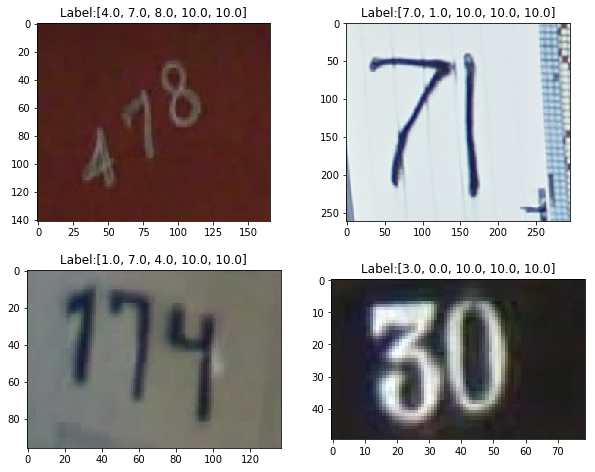

In [13]:
f, axarr = plt.subplots(2, 2, figsize=(10,8))
img_id = 0
for i in range(2):
    for j in range(2): 
        img = misc.imread(train_metadata['file_names'][img_id])
        axarr[i,j].imshow(img, cmap=plt.cm.Greys);
        axarr[i,j].set_title( "Label:" + str(train_metadata['labels'][img_id]))
        img_id += 1

In [14]:
# verify if the data is well balanced across the classes
def display_data_distribution(data):
    data_distribution = np.bincount(data)
    data_range = range(len(data))
    
    index = np.arange(len(data_distribution))
    plt.bar(index, data_distribution)
    plt.xlabel('Classes\n' + str(data_distribution))
    plt.ylabel('Samples')

    bar_width = 0.35
    plt.xticks(index + bar_width, data_range)
    
    plt.show()

Vamos a ver la distribución de las distintas imágenes, para conocer mejor nuestro dataset

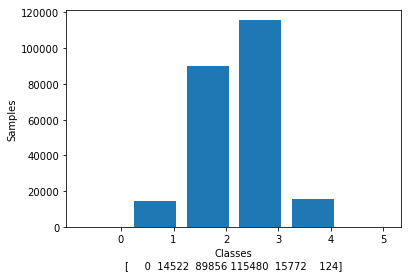

In [15]:
nbboxes = train_metadata['n_bboxes']
display_data_distribution(nbboxes)

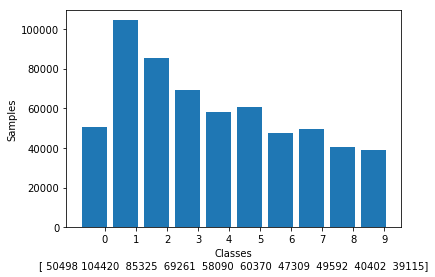

In [16]:
labels = train_metadata['labels']
clean_labels = list(chain.from_iterable(labels))
clean_labels = [x for x in clean_labels if x != 10.0]
display_data_distribution(clean_labels)

La mayor parte son de longitud 2 y 3, por lo que con seguridad nuestro modelo será mejor para esas longitudes pues hay mas muestras para entrenar

In [17]:
def calculate_dataset_distribution_rate(dataset_labels):
    data_distribution = np.bincount(dataset_labels)
    K = len(data_distribution)
    N = len(dataset_labels)
    c = 0
    for ck in data_distribution:
        c += (ck - (N/K))**2

    return (1.0/N)*((1.0/(K-1.0) * c) ** (0.5)) * 100

Vemos que el dataset está muy desbalanceado. Para ver como de desbalanceado está el dataset vamos a usar el Degree of Class Imbalance (DCI)  para poder medir el desbalanceado relativo para cada clase

In [18]:
print calculate_dataset_distribution_rate(clean_labels)

3.43635920205


Como se puede ver el DCI * 100 del nuetro training set no está cercano a cerom por lo que lo mejor será implementar un aumento de los datos utilizaremos un aumento sintético. 

Ahora veamos el dataset de test

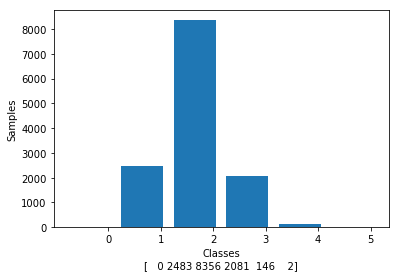

In [19]:
nbboxes = test_metadata['n_bboxes']
display_data_distribution(nbboxes)

La distribucion es muy distinta de la del dataset de training

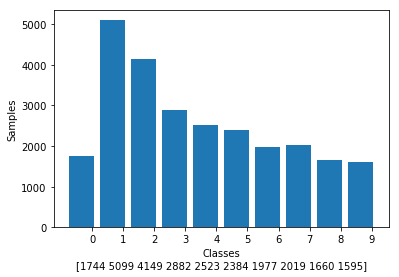

In [20]:
labels = test_metadata['labels']
clean_labels = list(chain.from_iterable(labels))
clean_labels = [x for x in clean_labels if x != 10.0]
display_data_distribution(clean_labels)